# Baseline

## Общая инициализация
Нужно выполнить в самом начале независимо от дальнейших действий

### Путь к каталогу, в котором лежит датасет
датасет представлен файлом `train.csv` и папкой `train`

In [1]:
base_folder = "./dataset/"

#### Инициализация путей 

In [2]:
import os.path as path

In [3]:
# path
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")

### Изучение аудиофайлов датасета

In [4]:
import os
import random

import librosa
import librosa.feature as F

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import Audio

In [5]:
# random filename from dir
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'5a4a1fe5b11fbb72474f.wav'

#### Спектрограмма

In [6]:
# spectrogram parameters
sample_rate = 11025

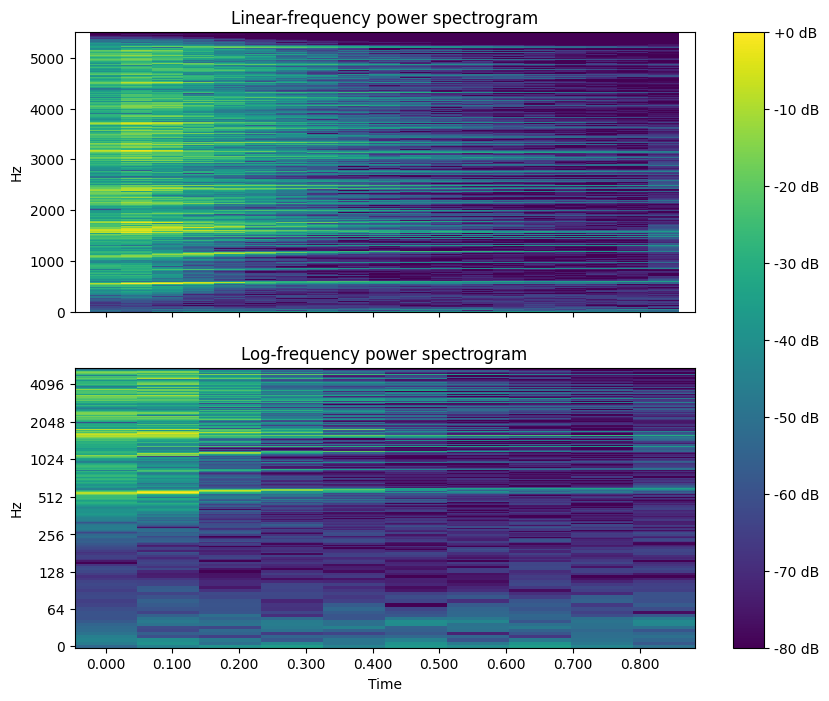

In [7]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

#### Mel-спектрограмма

In [8]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

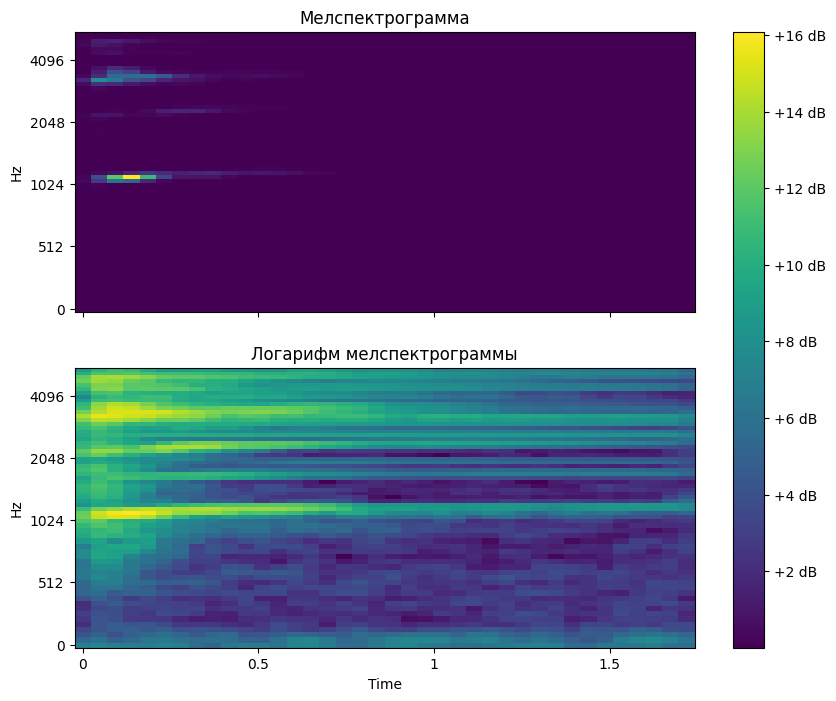

In [9]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels, 
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [10]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F


class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int):
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [11]:
# feature extraction parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

In [12]:
# extract features and store to `train_pickle` extracted features
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv, 
    train_folder, 
    train_pickle,
    labels_pickle,
    sample_rate, 
    n_fft, 
    hop_length, 
    n_mels
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [01:07, 84.31it/s] 


## Алгоритм детектирования

### Подготовительный этап

In [13]:
from typing import NoReturn
from pprint import pprint
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 12)

#### Добиваемся максимальной воспроизводимости
Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [16]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [17]:
random_state = 42

In [18]:
set_random_state(random_state)

In [19]:
torch.use_deterministic_algorithms(True)

In [20]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


In [21]:
torch.cuda.empty_cache()

### Архитектура нейронной сети

In [22]:
class DummyNetwork(nn.Module):
    """Neural network base architecture"""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=5, stride=(2, 2), device=device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1), device=device)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1), device=device)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1, 1), device=device)

        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.5)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.bn1 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn2 = nn.BatchNorm2d(num_features=96, device=device)
        self.bn3 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn4 = nn.BatchNorm2d(num_features=64, device=device)

        self.flat = nn.Flatten()

        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(80960, 1000, device=device)
        self.fc2 = nn.Linear(1000, 41, device=device)

    def forward(self, x):
        # UPD: различные эксперименты со слоями
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = F.relu(x)
#         x = self.mp(x)
#         x = self.dropout4(x)

        x = self.flat(x)

        # здесь можно еще добавить полносвязный слой или слои
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [23]:
set_random_state(random_state) # try to run this cell several times
                               # then comment this line and run it several times again
                               # * pay attention at tensors values

# random 4D tensor
random_input = torch.randn(1, 1, 64, 128, requires_grad=True, device=device)

print(f"Исходный тензор {list(random_input.shape)}:")
pprint(random_input)

# create neural network instance
network = DummyNetwork()

# pass data throught the neural network
output = network(random_input)

print(f"\nТензор на выходе нейронной сети {list(output.shape)}:")
pprint(output)

Исходный тензор [1, 1, 64, 128]:
tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -1.2072, -0.2438, -0.6784],
          [ 0.1973,  0.9782, -0.0287,  ..., -0.9226,  0.7893, -1.8010],
          [-1.9351,  1.1007,  0.0251,  ..., -0.6872, -0.0919, -0.7132],
          ...,
          [-1.0439,  0.7082,  0.0871,  ..., -0.2350,  0.6789, -0.2683],
          [ 0.1728,  0.9311,  0.9508,  ..., -1.2910, -0.3644,  0.9805],
          [-0.5130,  0.6719, -0.1551,  ..., -1.0449,  1.5397, -2.0042]]]],
       device='cuda:0', requires_grad=True)

Тензор на выходе нейронной сети [1, 41]:
tensor([[ 0.7719,  0.7469, -0.5177, -1.0570, -0.5427,  0.2459,  0.4384, -1.2959,
          0.3549, -0.8679,  0.8993, -0.2466,  0.7081, -0.3103, -0.5567, -0.7233,
          0.2540, -1.4448, -0.9818, -0.5512, -0.9234, -0.7542,  0.3490, -0.7312,
          0.7293, -1.8940, -0.3079, -0.6460, -0.7587,  0.5672,  0.5697, -0.7443,
          0.2367, -0.3732,  1.1130, -0.1187,  0.2614, -1.6523,  0.2335, -0.1058,
          0.0287]], device

### Шаг оптимизации

In [24]:
import torch.optim as optim

In [25]:
set_random_state(random_state)


# choose loss function
criterion = nn.CrossEntropyLoss()

# choose and tune optimizer
optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 128, requires_grad=True, device=device)
print(f"Тензор на входе сети {list(random_input.shape)}:")
pprint(random_input)

output = network(random_input)
print(f"\nТензор на выходе сети {list(output.shape)}:")
pprint(output)

target = torch.randint(5, (3,), dtype=torch.long, device=device)
print(f"\nТензор с целевыми значениями {list(target.shape)}:")
pprint(target)

loss = criterion(output, target)
print("\nЗначение функции потерь:", loss.item())

# backpropagation
loss.backward()

# next step
optimizer.step() 

Тензор на входе сети [3, 1, 64, 128]:
tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -1.2072, -0.2438, -0.6784],
          [ 0.1973,  0.9782, -0.0287,  ..., -0.9226,  0.7893, -1.8010],
          [-1.9351,  1.1007,  0.0251,  ..., -0.6872, -0.0919, -0.7132],
          ...,
          [-1.0439,  0.7082,  0.0871,  ..., -0.2350,  0.6789, -0.2683],
          [ 0.1728,  0.9311,  0.9508,  ..., -1.2910, -0.3644,  0.9805],
          [-0.5130,  0.6719, -0.1551,  ..., -1.0449,  1.5397, -2.0042]]],


        [[[-0.5852, -0.9346,  0.9684,  ..., -0.7158,  0.6009, -0.1343],
          [-0.0884,  1.5620, -2.4534,  ...,  0.6949,  0.3456, -0.6991],
          [ 0.0722,  0.7010,  2.5725,  ..., -0.6654, -0.7965, -1.2416],
          ...,
          [-2.0138,  0.4818, -0.1514,  ..., -0.3902,  0.1770, -0.0484],
          [ 0.5613,  0.3913, -0.0898,  ..., -1.7750,  0.6635,  0.1784],
          [ 0.6133, -0.0807, -0.2016,  ..., -0.1449, -0.9527,  0.0830]]],


        [[[-0.9702,  2.1277, -1.3457,  ...,  0.9696,  0.3215

### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [26]:
import pickle

In [27]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [28]:
def prepare_shape(feature):
    # UPD: изменение N=64 на 128 и испоьзование pad=0
    tmp = feature
    N = 128 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        tmp = np.hstack((tmp, np.zeros_like(tmp)))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [29]:
# UPD: использование stratified train test split
from sklearn.model_selection import train_test_split
validation_set_size = 1000
test_set_size = validation_set_size / len(train_data)

X_, Y_ = [], []
for i, row in enumerate(train_data):
    feature = prepare_shape(row['feature'])
    X_.append(feature)
    Y_.append(row['label_id'])
    
x_tr, x_val, y_tr, y_val = train_test_split(np.array(X_), np.array(Y_), stratify=Y_, test_size=test_set_size)

# x_val = []
# y_val = []

# x_tr = []
# y_tr = []

# for i, row in enumerate(train_data):
#     feature = prepare_shape(row['feature'])
#     if i < validation_set_size:
#         x_val.append(feature)
#         y_val.append(row['label_id'])
#     else:
#         x_tr.append(feature)
#         y_tr.append(row['label_id'])

# x_val = np.asarray(x_val)
# x_tr = np.asarray(x_tr)

# y_val = np.asarray(y_val)
# y_tr = np.asarray(y_tr)

print(f"""
Train set:
    x.shape: {x_tr.shape}
    y.shape: {y_tr.shape}

Validation set:
    x.shape: {x_val.shape}
    y.shape: {y_val.shape}
""")


Train set:
    x.shape: (4683, 1, 64, 128)
    y.shape: (4683,)

Validation set:
    x.shape: (1000, 1, 64, 128)
    y.shape: (1000,)



In [30]:
from torch.utils.data import Dataset

In [31]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(self.x[idx], device=device)

In [32]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [33]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(6, 'Cello')

In [34]:
import librosa
import matplotlib.pyplot as plt

In [35]:
sample_rate = 11025

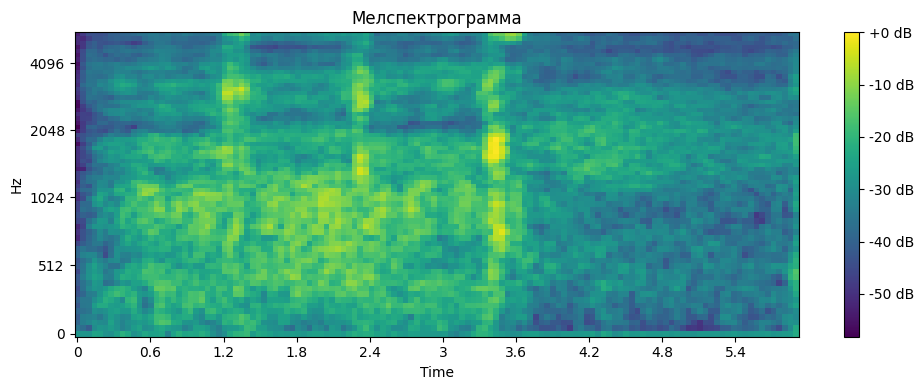

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [37]:
from torch.utils.data import DataLoader

In [38]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [39]:
import time
from sklearn.metrics import accuracy_score

In [40]:
start_time = time.time()

n_epoch = 100

set_random_state(random_state)

criterion = nn.CrossEntropyLoss()
network = DummyNetwork()

# UPD: изменение оптимизатора с SGD на AdamW
optimizer = optim.AdamW(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    
    if e % 10 == 0:
        print(f'epoch #{e+1}')
    
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))

        target = y
        targets.append(target)

        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)

    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    
    if e % 10 == 0:
        print(f'[train] mean loss: {train_loss[-1]}')
        print(f'[train] accuracy:  {acc}')

    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            #optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
            #loss.backward()
            #optimizer.step()

        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)

        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        
        if e % 10 == 0:
            print(f'[val] mean loss:   {val_loss[-1]}')
            print(f'[val] accuracy:    {acc}', end="\n\n")

print(f"Execution time: {(time.time() - start_time):.2f} seconds")

epoch #1
[train] mean loss: 56.17081513404846
[train] accuracy:  0.07260303224428785
[val] mean loss:   24.39238594055176
[val] accuracy:    0.075

epoch #11
[train] mean loss: 2.060477364581564
[train] accuracy:  0.43647234678624813
[val] mean loss:   2.563536539077759
[val] accuracy:    0.366

epoch #21
[train] mean loss: 1.1778119286765223
[train] accuracy:  0.6679478966474482
[val] mean loss:   2.6390219736099243
[val] accuracy:    0.433

epoch #31
[train] mean loss: 0.6173627109631248
[train] accuracy:  0.8150758061071962
[val] mean loss:   3.3286780738830566
[val] accuracy:    0.44

epoch #41
[train] mean loss: 0.3560895392752212
[train] accuracy:  0.8930172966047405
[val] mean loss:   3.6361623287200926
[val] accuracy:    0.445

epoch #51
[train] mean loss: 0.25575751260570856
[train] accuracy:  0.9220585095024557
[val] mean loss:   4.549812650680542
[val] accuracy:    0.447

epoch #61
[train] mean loss: 0.48659067743498347
[train] accuracy:  0.915652359598548
[val] mean loss:  

In [41]:
def plot_validation_curve():
    
    epochs = range(1, n_epoch+1)

    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

    xticks = range(1, n_epoch+1, n_epoch // 10) if n_epoch > 10 else epochs

    # draw loss
    ax_top.plot(epochs, train_loss, 'r', label='train')
    ax_top.plot(epochs, val_loss, 'b', label='validation')

    ax_top.set(
        title='Loss',
        xlabel='Epoch number',
        ylabel='Loss value',
        ylim=[0, max(max(train_loss), max(val_loss)) + 1],
    )
    ax_top.legend(
        title="Выборка",
    )
    ax_top.grid()

    # draw accuracy
    ax_bottom.plot(epochs, train_acc, 'r', label='train')
    ax_bottom.plot(epochs, val_acc, 'b', label='validation')

    ax_bottom.set(
        title='Accuracy',
        xlabel='Epoch number',
        ylabel='Accuracy value',
        xticks=xticks,
        ylim=[0, 1],
    )
    ax_bottom.legend(
        title="Выборка",
    )
    ax_bottom.grid()

    fig.suptitle("Кривые обучения")

    plt.show()

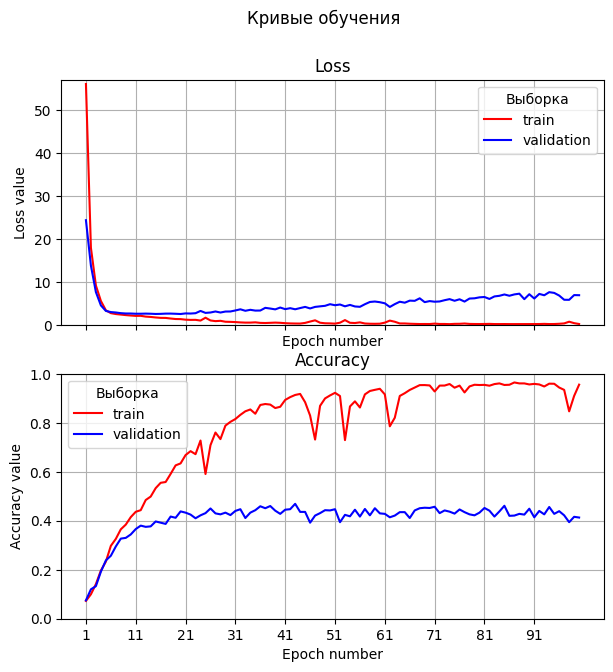

In [42]:
plot_validation_curve()

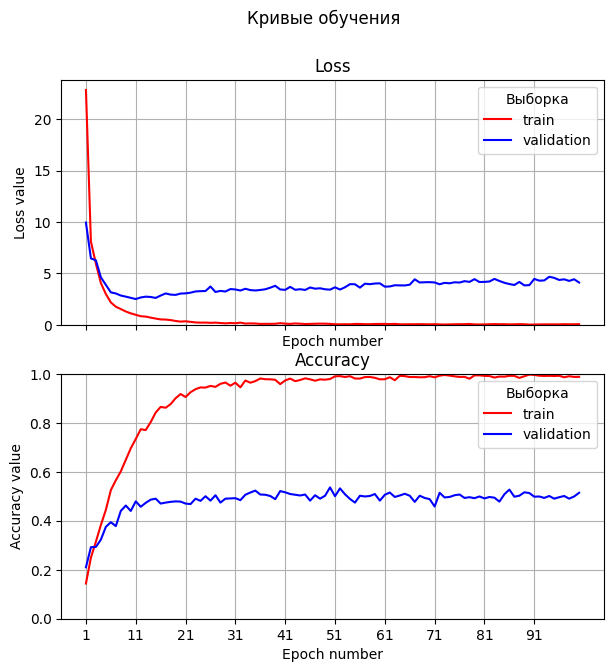

In [86]:
# Кривые обучения при удалении одного сверточного блока (дал приемлимый результат)
plot_validation_curve()

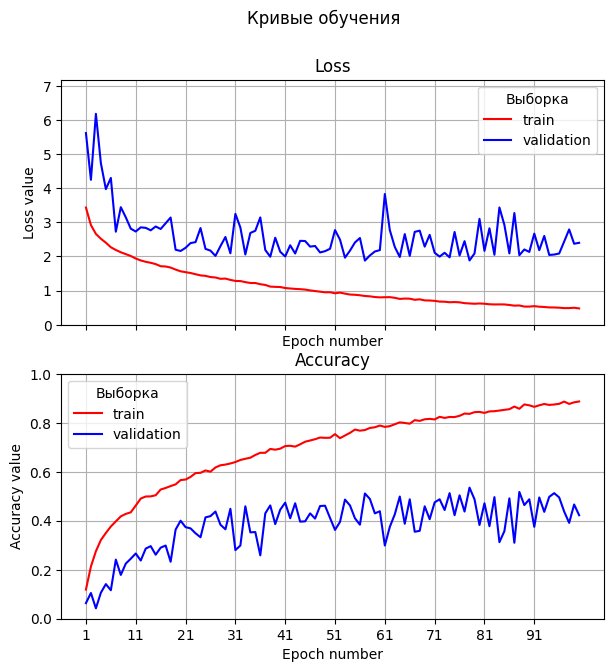

In [54]:
# Кривые обучения для исходных значений гиперпараметров
plot_validation_curve()

### Выводы:


При *исходных* значениях гиперпараметров (количество эпох было выставлено 100 вместо исходного 50 для наглядности) получились следующие результаты с лучшей комбинацией метрик:
- Общее `время` обучения: 285.51 seconds
- Модель ловит `переобучение` уже на 30-ой эпохе (см. графики выше), т.к. значения на train сильно выше, чем на validation
- `train mean loss`: 0.6993144524594148
- `train accuracy`:  0.8134343641204178
- `val mean loss`:   2.109064817428589
- `val accuracy`:    0.475

**В ходе данной лабораторной работы были сделаны следующие изменения:**


- Количество `эпох`: *100*
- `Оптимизатор`: *AdamW* (выбор оптимизатора сложная задача, можно руководствоваться различными критериями подбора оптимизатора в конкретной задаче [см. таблицу ниже])
- `Разделение` на test/val: *Stratified* (в таком случае вадлидационный набор содержит примерно такой же процент образцов каждого целевого класса, как и полный набор)


`Архитектура` рассматриваемой сети заслуживает отдельного внимания:
- Неизменная модель при перечисленных выше изменениях давала точность<=0.517, однако явно прослеживалось переобучение (*train mean loss*=0.021 и *val mean loss*=4.498)
- С одной стороны прослеживается переобучение, и был выбран один из подходов борьбы с ней: переход к более простому семейству моделей (были убраны 2 сверточных блока), однако в данном случае модель все-равно переобучалась и давала показатели хуже (точность<=0.493 на валидации)
- Модель с более сложной структурой (3 сверточных блока и 2 Linear-слоя) давала точность<=0.48 на валидации и сильно переобучалась
- При удалении одного сверточного блока точность=0.516, однако модель более устойчивая (**было решено выбрать эту архитектуру**)
- Модель с более сложной структурой (добавление еще одного Linear-слоя и удаление одного сверточного блока) также переобучалась, но давала точность<=0.484 на валидации
- Модель с более сложной структурой (добавление 4-го сверточного блока) не давала высокой производительности (точность<=0.485 на валидации)

После чего были сделаны еще изменения:
- Изменение N=128 (`размер во времени`)
- `Дозаполнение` сигнала нулями до N
- Усиление `регуляризации` (увеличение параметра dropout до 0.5) и добавление полносвязанного слоя

Однако это только *ухудшило* показатели метрик

Полученные результаты:
- Общее `время` обучения: ~200 seconds
- Модель ловит `переобучение` уже на ~15 эпохе
- `train mean loss`: 0.10592440923109003
- `train accuracy`:  0.9726670937433269
- `val mean loss`:   3.3948125553131105
- `val accuracy`:    0.516

Сверточные нейронные сети отлично подходят для задач, связанных с анализом акустических явлений, благодаря некоторым свойствам:
1) Небольшое количество обучаемых параметров и быстрая скорость обучения (по сравнению с полносвязной нейронной сетью, что заметно при увеличении Linear слоев)
2) Возможность распараллеливания вычислений
3) Устойчивость к сдвигу позиции объекта во входных данных (при обучении свёрточная нейронная сеть сдвигается по частям объекта)

Однако, такое сложное семейство алгоритмов машинного обучения обычно требует большой объем данных для выявления закономерностей, и поэтому, на данной достаточно небольшой выборке быстро переобучается (что видно по графикам). Для наибольшей производительности по метрикам, имеет смысл либо увеличить выборку (сбор данных, аугментация), либо выполнить переход к использованию более простых моделей (SVM, GradientBoosting...) 

*Таблица с различными оптимизаторами*

![image](./resources/optimzers.png)